In [1]:
# Install TensorFlow
# !pip install -q tensorflow-gpu==2.0.0-rc0

#try:
#  %tensorflow_version 2.x  # Colab only.
#except Exception:
#  pass

import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
# 載入更多模組
from tensorflow.keras.layers import Input, Dense, LeakyReLU, Dropout, \
  BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os

In [3]:
# 準備數據
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map inputs to (-1, +1) for better training
x_train, x_test = x_train / 255.0 * 2 - 1, x_test / 255.0 * 2 - 1
print("x_train.shape:", x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
x_train.shape: (60000, 28, 28)


In [4]:
# 將數據壓平  D = H * W
N, H, W = x_train.shape
D = H * W
x_train = x_train.reshape(-1, D)
x_test = x_test.reshape(-1, D)

In [5]:
# latent space 維度
latent_dim = 100

In [6]:
# 建立 generator 模型
def build_generator(latent_dim):
  i = Input(shape=(latent_dim,))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization(momentum=0.7)(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

In [7]:
# 建立 discriminator 模型
def build_discriminator(img_size):
  i = Input(shape=(img_size,))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)
  model = Model(i, x)
  return model

In [8]:
# 編譯兩者，準備訓練


# 建立並編譯鑑別器
discriminator = build_discriminator(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy'])

# 建立並編譯合併模型
generator = build_generator(latent_dim)

# 從latent space產生雜訊樣本當作輸入
z = Input(shape=(latent_dim,))

# 將雜訊通過產生器產生影像
img = generator(z)

# 確認只有產生器被訓練
discriminator.trainable = False

# 輸出假影像, 但我們標籤為真!
fake_pred = discriminator(img)

# 產生合併模型
combined_model = Model(z, fake_pred)

# 編譯合併模型
combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))

In [9]:
# 訓練 GAN


# 設定系數
batch_size = 32
epochs = 30000
sample_period = 200 # every `sample_period` steps generate and save some data


# 產生批次標籤，當呼叫train_on_batch時使用
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

# 儲存損失資訊
d_losses = []
g_losses = []

# 儲存產生影像的檔案夾
if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [10]:
# 產生並儲存一格柵亂數影像組的函數
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(H, W), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig("gan_images/%d.png" % epoch)
  plt.close()

In [11]:
# 主訓練迴圈
for epoch in range(epochs):
  ###########################
  ### Train discriminator ###
  ###########################
  
  # Select a random batch of images
  idx = np.random.randint(0, x_train.shape[0], batch_size)
  real_imgs = x_train[idx]
  
  # Generate fake images
  noise = np.random.randn(batch_size, latent_dim)
  fake_imgs = generator.predict(noise)
  
  # Train the discriminator
  # both loss and accuracy are returned
  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)
  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc  = 0.5 * (d_acc_real + d_acc_fake)
  
  
  #######################
  ### Train generator ###
  #######################
  
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # do it again!
  noise = np.random.randn(batch_size, latent_dim)
  g_loss = combined_model.train_on_batch(noise, ones)
  
  # Save the losses
  d_losses.append(d_loss)
  g_losses.append(g_loss)
  
  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, \
      d_acc: {d_acc:.2f}, g_loss: {g_loss:.2f}")
  
  if epoch % sample_period == 0:
    sample_images(epoch)


epoch: 1/30000, d_loss: 0.67,       d_acc: 0.53, g_loss: 0.51
epoch: 101/30000, d_loss: 0.14,       d_acc: 0.95, g_loss: 3.21
epoch: 201/30000, d_loss: 0.44,       d_acc: 0.80, g_loss: 1.61
epoch: 301/30000, d_loss: 0.71,       d_acc: 0.48, g_loss: 0.61
epoch: 401/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.64
epoch: 501/30000, d_loss: 0.67,       d_acc: 0.48, g_loss: 0.65
epoch: 601/30000, d_loss: 0.68,       d_acc: 0.47, g_loss: 0.65
epoch: 701/30000, d_loss: 0.69,       d_acc: 0.53, g_loss: 0.65
epoch: 801/30000, d_loss: 0.72,       d_acc: 0.42, g_loss: 0.71
epoch: 901/30000, d_loss: 0.70,       d_acc: 0.47, g_loss: 0.70
epoch: 1001/30000, d_loss: 0.69,       d_acc: 0.55, g_loss: 0.69
epoch: 1101/30000, d_loss: 0.66,       d_acc: 0.58, g_loss: 0.77
epoch: 1201/30000, d_loss: 0.67,       d_acc: 0.47, g_loss: 0.73
epoch: 1301/30000, d_loss: 0.67,       d_acc: 0.66, g_loss: 0.74
epoch: 1401/30000, d_loss: 0.68,       d_acc: 0.61, g_loss: 0.73
epoch: 1501/30000, d_loss: 0.64,     

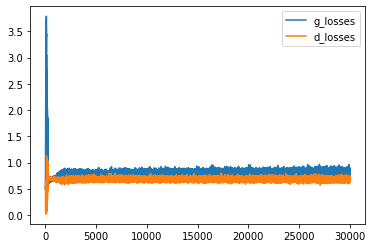

In [12]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [13]:
!ls gan_images

0.png	   13800.png  17800.png  21600.png  25600.png  29600.png  6600.png
10000.png  14000.png  18000.png  21800.png  25800.png  29800.png  6800.png
1000.png   1400.png   1800.png	 22000.png  26000.png  3000.png   7000.png
10200.png  14200.png  18200.png  2200.png   2600.png   3200.png   7200.png
10400.png  14400.png  18400.png  22200.png  26200.png  3400.png   7400.png
10600.png  14600.png  18600.png  22400.png  26400.png  3600.png   7600.png
10800.png  14800.png  18800.png  22600.png  26600.png  3800.png   7800.png
11000.png  15000.png  19000.png  22800.png  26800.png  4000.png   8000.png
11200.png  15200.png  19200.png  23000.png  27000.png  400.png	  800.png
11400.png  15400.png  19400.png  23200.png  27200.png  4200.png   8200.png
11600.png  15600.png  19600.png  23400.png  27400.png  4400.png   8400.png
11800.png  15800.png  19800.png  23600.png  27600.png  4600.png   8600.png
12000.png  16000.png  20000.png  23800.png  27800.png  4800.png   8800.png
1200.png   1600.png   2000.png

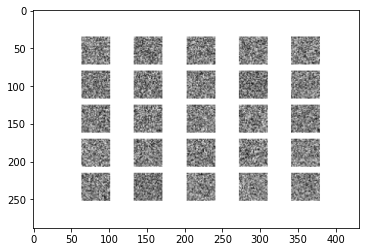

In [14]:
from skimage.io import imread
a = imread('gan_images/0.png')
plt.imshow(a)

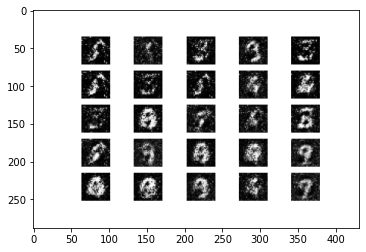

In [15]:
a = imread('gan_images/1000.png')
plt.imshow(a)

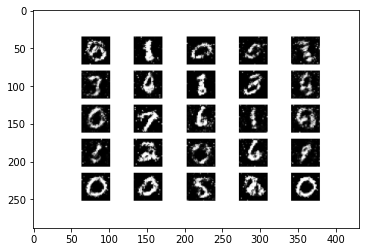

In [16]:
a = imread('gan_images/5000.png')
plt.imshow(a)

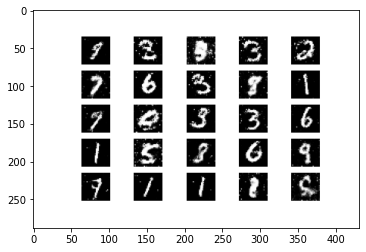

In [17]:
a = imread('gan_images/10000.png')
plt.imshow(a)

In [ ]:
a = imread('gan_images/20000.png')
plt.imshow(a)

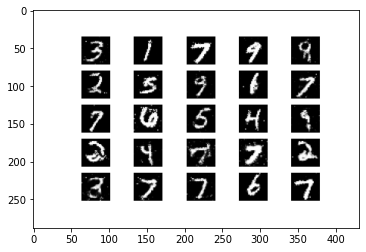

In [ ]:
a = imread('gan_images/29800.png')
plt.imshow(a)